<a href="https://colab.research.google.com/github/dirksen/ml-playground/blob/main/Digging_For_Good_Debates_with_Zero_Shot_Stance_Detection_from_%F0%9F%A4%97_Hugging_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debate Mining

When watching Youtube vidoes on hot-button topics, I would often deep dive into the comments section to look for good arguments and counter arguments. Youtube organize the comments section into two levels: top level comments that address to the video, and replies to those comments. Often I found good debates among these reply threads that brought fresh angles and insights. Unfortunately, Youtube's UI make it very difficult to dig up good debates:
1. Youtube doesn't sort comments by the number of replies. I have to scroll and skip a lot of comments of zero replies just to access the reply threads.
2. Not all threads present good debates. Many of them are one-sided, like mini-echo-chambers. It's time consuming to read tens of replies only to find out there isn't much debate going in the thread.

This notebook attempts to mine good debates from the video comment threads, by using Youtube API to scrape top N most replied comment threads, and then use HuggingFace's ML model to rank them. It will render the threads at the end for easy reading.

## Ranking Strategy

The goal is to score each thread that reflects how good a debate the thread is. Based on observations, I found two indicators for a good debate:

1. Debate is like a tennis game: each side takes turn to present their arguments. The more rounds of back and forth, the more exciting the debate is.
2. A good debate should also be balanced, i.e. the number of pro arguments and con arguments should be close. A big delta between the two indicates the debate is one-sided.

Obviously, both indicators depend on the classification of each reply as either pro argument or con argument. This is stance detection.

## Stance Detection using the 🤗 Hugging Face ML Platform

[Hugging Face](https://huggingface.co/) is an open source data science and machine learning platform, like a GitHub for AI. It hosts many AI models contributed by others. In this exercise, I will use the [DeBERTa-Large model](https://huggingface.co/microsoft/deberta-large) for stance detection. Given a claim and a comment to that claim, stance detection is to figure out if the comment is supportive, against, or neutral to the claim. E.g. giving the claim `the earth is flat`, comment `yes it is` is supportive in stance.

Let's see how it works in actions:

In [1]:
%%capture
!pip install torch pandas google-api-python-client transformers ipdb

import ipdb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import googleapiclient.discovery
from transformers import pipeline


Let's initiate a zero-shot classifier:

In [2]:
classifier = pipeline("zero-shot-classification", model='MoritzLaurer/deberta-v3-large-zeroshot-v1', device = 'cuda')

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Here defines a function that takes one claim, and a list of comments, and then returns a list of stance corresponding to each comment (and the confidence for each outcome):

In [3]:
def detect_stance(claim, list_of_comments, classifier=classifier):
  # Like ChatGPT, it works by prompting
  prompt = 'The author of this comment {} the claim: `%s`.' % claim
  # lables for 3 possible stance outcomes
  labels = ['supports', 'opposes', 'does not express an opinion about']
  res = classifier(list_of_comments, labels, hypothesis_template = prompt, multi_item = False)
  # per https://github.com/huggingface/transformers/issues/22387, reset the call_count to inhibit a warning
  classifier.call_count = 0
  df = pd.DataFrame()
  df['comments'] = list_of_comments
  df['stance'] = [outcome['labels'][0] for outcome in res]
  df['claim'] = [claim] * len(list_of_comments)
  return df

Let's run the function over one cliam and a list of comments to that claim:

In [4]:
claim = 'The earth is flat.'
comments = [
           'Yes, it is flat.',
           'The earth is actually round.',
           'Pluto is not a planet.'
           ]
detect_stance(claim, comments)


,comments,stance,claim
0,"Yes, it is flat.",supports,The earth is flat.
1,The earth is actually round.,opposes,The earth is flat.
2,Pluto is not a planet.,does not express an opinion about,The earth is flat.


## Scraping Comment Threads
We need API keys to access Youtube API:

In [5]:
from google.colab import userdata
DEVELOPER_KEY = userdata.get('ytDevKey')

To speed up development iteration, cache the scraping results using `Memory` and `lru_cache`:

In [6]:
from joblib import Memory
from functools import lru_cache

memory = Memory('cache/')

`TARGET_VIDEO_ID` is the video we want to mine debates from (you can watch the video [here](https://www.youtube.com/watch?v=5-rhLH5lYi4)):

In [7]:
# Change TARGET_VIDEO_ID to your liking
TARGET_VIDEO_ID = 'EzUxxY2sYys'
print(f'Video can be visited here: https://www.youtube.com/watch?v={TARGET_VIDEO_ID}')


Video can be visited here: https://www.youtube.com/watch?v=EzUxxY2sYys


Scrape all top level comments and get a count of replies of each. Note Youtube chunks the comments by pages. The generator method `pageFlipper` helps going through all the pages of comments:

In [8]:

api_service_name = "youtube"
api_version = "v3"

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey = DEVELOPER_KEY)

def pageFlipper(func, **kwargs):
  nextPageToken = None
  while True:
    kwargs['pageToken'] = nextPageToken
    request = func(**kwargs)
    response = request.execute()
    yield response
    # last page
    if 'nextPageToken' not in response:
      break
    nextPageToken=response['nextPageToken']

paginatedResults = pageFlipper(youtube.commentThreads().list,
    videoId=TARGET_VIDEO_ID,
    textFormat='plainText',
    part='snippet',
  )

extract = lambda comment: dict(
      id=comment['id'],
      replies=comment['snippet']['totalReplyCount'],
      author=comment['snippet']['topLevelComment']['snippet']['authorDisplayName'],
      publishedAt=comment['snippet']['topLevelComment']['snippet']['publishedAt'],
      text=comment['snippet']['topLevelComment']['snippet']['textOriginal'],
)

@lru_cache()
@memory.cache
def fetch_top_comments():
  entries = [extract(comment) for page in paginatedResults for comment in page['items']]
  return pd.DataFrame(entries).set_index(['id'])

top_comments_df = fetch_top_comments()
top_comments_df


________________________________________________________________________________
[Memory] Calling __main__--content-<ipython-input-2c98fdb0c006>.fetch_top_comments...
fetch_top_comments()
_______________________________________________fetch_top_comments - 1.7s, 0.0min


,replies,author,publishedAt,text
id,,,,
UgwtxHuJV100f8JaG8N4AaABAg,0,@user-if5gs9nl6n,2023-12-15T16:52:03Z,The atrocities of October 7th serve as a stark...
Ugyeg7tKk-yWkhgG0NN4AaABAg,0,@rebekavital,2023-12-15T14:19:08Z,"Tareq is looking with a magnifying glass, tryi..."
Ugy_RAEM2Nva10L13Hh4AaABAg,0,@algon1024,2023-12-14T22:21:05Z,"Ok, one question, if Israel already won wars a..."
UgyYyi0W_a-KrTVFPdZ4AaABAg,0,@algon1024,2023-12-14T21:33:37Z,Really? Hamas objective is clearly stated on i...
Ugx9YBkY_4FYaOflocZ4AaABAg,0,@schrecksekunde2118,2023-12-14T15:15:16Z,whoever loves the Jewish people makes them fac...
...,...,...,...,...
UgwW7BLBgwHt6wcvlXh4AaABAg,38,@terrencebushell9588,2023-12-05T10:59:51Z,I am Pro Palestinian but there is no way they ...
UgyfMzluxoZZ_LaXewJ4AaABAg,5,@yoelmarson4049,2023-12-05T10:45:18Z,As much as I wanted to listen to this to gain ...
UgxCgpOfhE1KOt53t3B4AaABAg,7,@khurram4589,2023-12-05T10:29:52Z,Mr James Clark is the best. Recommending him t...


Download replies for each top comments (the replies are also paginated, hence the usage of `pageFlipper` again):

In [9]:
replies = []
for top_comment_id, _ in top_comments_df.iterrows():
  paginatedResults = pageFlipper(youtube.comments().list,
      parentId=top_comment_id,
      textFormat='plainText',
      part='snippet',
    )
  for comment in [comment for page in paginatedResults for comment in page['items']]:
    entry = dict(
        id= comment['id'],
        parent=top_comment_id,
        parent_text=_.text,
        replies='',
        author= comment['snippet']['authorDisplayName'],
        publishedAt= comment['snippet']['publishedAt'],
        reply_text= comment['snippet']['textOriginal'],
    )
    replies.append(entry)

@lru_cache()
@memory.cache
def fetch_replies():
  return pd.DataFrame(replies).set_index('id').sort_values(['parent_text', 'publishedAt'])

replies_df = fetch_replies()
replies_df

________________________________________________________________________________
[Memory] Calling __main__--content-<ipython-input-8ced58408f0d>.fetch_replies...
fetch_replies()
____________________________________________________fetch_replies - 0.0s, 0.0min


,parent,parent_text,replies,author,publishedAt,reply_text
id,,,,,,
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xy0MnuEOpt,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@xiomaraortiz5158,2023-12-06T00:58:23Z,Agreed
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xy3Z2hpKjS,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@pcolt4,2023-12-06T01:26:16Z,This narrative is completely false. It is Isra...
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xyJut5sLYZ,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@Post_3D_Space-time_Data_Stream,2023-12-06T03:49:12Z,Ha-MESS will never agree to any peace treaty. ...
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xytob0oimH,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@dankoppel6271,2023-12-06T09:11:39Z,Unfortunately you make a lot of sense.
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xzJzW-Xm_O,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@Kooky_Duzzfutz,2023-12-06T13:09:04Z,"""so until there’s a massive ideological shift ..."
...,...,...,...,...,...,...
UgwUMnqOaEM0aurKto14AaABAg.9xxBJYUjCXI9xysU_JRS0i,UgwUMnqOaEM0aurKto14AaABAg,Wow Ezra this is exactly the info I've been wa...,,@valtracey6180,2023-12-06T09:00:02Z,I totally agree! I have listened to hundreds ...
UgwUMnqOaEM0aurKto14AaABAg.9xxBJYUjCXI9y4Yvhiita_,UgwUMnqOaEM0aurKto14AaABAg,Wow Ezra this is exactly the info I've been wa...,,@rosamundeandorfeo,2023-12-08T23:15:04Z,@@valtracey6180 yes! It's Israel's responsibil...
UgxcW1SU78cyJwRMlpV4AaABAg.9xwls1KtG1Q9xx8AwN7n6e,UgxcW1SU78cyJwRMlpV4AaABAg,You folks are next. Hamas wants the same thin...,,@keep-ukraine-free528,2023-12-05T16:47:26Z,"@peopleofisrael7958 You offer fear & hatred, f..."


Group `replies_df` into threads by `parent_text` (which is the top comment):

In [10]:
threads_df = replies_df.groupby(['parent_text']).agg(list).reset_index()[['parent_text', 'reply_text']]
threads_df = threads_df.rename(columns={'parent_text': 'top_comment', 'reply_text':'replies'})
threads_df

,top_comment,replies
0,#1 problem is that the people do not want a pe...,"[Agreed, This narrative is completely false. I..."
1,0:10: 🔍 The video discusses the need to hold t...,[concessions don't work with Jihadis.]
2,"32:35 ""will not accept a state that is majorit...",[Israel has currently about 7 million Jewish c...
3,"A Palestinian ""concession"" is offering somethi...",[Black Africans came to the Americans in chain...
4,"A great war strategy starts with ""understandin...","[Not a peace strategy, huh?, @@JohnMoranLet’s ..."
...,...,...
70,What right does the British have to promise pe...,[Why don't you know the situation before comme...
71,"With respect to the guest, Hamas is losing bad...",[I don't understand how they can be both victo...
72,Wow Ezra this is exactly the info I've been wa...,[I totally agree! I have listened to hundreds...
73,You folks are next. Hamas wants the same thin...,"[@peopleofisrael7958 You offer fear & hatred, ..."


Since we have the comment threads, we need to rank them. Based on observations, I found two indicators for a good debate:
1. Debate is like a tennis game: each side takes turn to present their arguments. The more rounds of back and forth, the more exciting the debate is.
2. A good debate should also be balanced, i.e. the number of pro arguments and con arguments should be close. A big delta between the two indicates the debate is one-sided.

Obviously, both indicators depend on the classification of each reply as either pro argument or con argument. This is where HuggingFace can help. I set up each top level comment as the target, and ask HuggingFace to classify the stance of each reply under that comment.

In [11]:
def detect_and_return_stance_as_a_list(claim, list_of_comments):
  df = detect_stance(claim, list_of_comments)
  return df.stance.tolist()

stance_rslt = threads_df.apply(lambda x: detect_and_return_stance_as_a_list(x.top_comment, x.replies), axis=1)
stance_rslt

Join all the stance lists into a new column back to `replies_df`:

In [12]:
replies_df['stance'] = stance_rslt.squeeze().explode().tolist()
replies_df

,parent,parent_text,replies,author,publishedAt,reply_text,stance
id,,,,,,,
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xy0MnuEOpt,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@xiomaraortiz5158,2023-12-06T00:58:23Z,Agreed,supports
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xy3Z2hpKjS,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@pcolt4,2023-12-06T01:26:16Z,This narrative is completely false. It is Isra...,opposes
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xyJut5sLYZ,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@Post_3D_Space-time_Data_Stream,2023-12-06T03:49:12Z,Ha-MESS will never agree to any peace treaty. ...,supports
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xytob0oimH,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@dankoppel6271,2023-12-06T09:11:39Z,Unfortunately you make a lot of sense.,supports
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xzJzW-Xm_O,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@Kooky_Duzzfutz,2023-12-06T13:09:04Z,"""so until there’s a massive ideological shift ...",supports
...,...,...,...,...,...,...,...
UgwUMnqOaEM0aurKto14AaABAg.9xxBJYUjCXI9xysU_JRS0i,UgwUMnqOaEM0aurKto14AaABAg,Wow Ezra this is exactly the info I've been wa...,,@valtracey6180,2023-12-06T09:00:02Z,I totally agree! I have listened to hundreds ...,supports
UgwUMnqOaEM0aurKto14AaABAg.9xxBJYUjCXI9y4Yvhiita_,UgwUMnqOaEM0aurKto14AaABAg,Wow Ezra this is exactly the info I've been wa...,,@rosamundeandorfeo,2023-12-08T23:15:04Z,@@valtracey6180 yes! It's Israel's responsibil...,supports
UgxcW1SU78cyJwRMlpV4AaABAg.9xwls1KtG1Q9xx8AwN7n6e,UgxcW1SU78cyJwRMlpV4AaABAg,You folks are next. Hamas wants the same thin...,,@keep-ukraine-free528,2023-12-05T16:47:26Z,"@peopleofisrael7958 You offer fear & hatred, f...",opposes


Change the text labels for stance into numbers: 1, 0 -1, meaning support, neutral, and against repectively:

In [13]:
replies_df['stance'].replace(regex = {r'supports':1, r'opposes':-1, r'does not express an opinion about': 0}, inplace = True)
replies_df

,parent,parent_text,replies,author,publishedAt,reply_text,stance
id,,,,,,,
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xy0MnuEOpt,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@xiomaraortiz5158,2023-12-06T00:58:23Z,Agreed,1
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xy3Z2hpKjS,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@pcolt4,2023-12-06T01:26:16Z,This narrative is completely false. It is Isra...,-1
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xyJut5sLYZ,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@Post_3D_Space-time_Data_Stream,2023-12-06T03:49:12Z,Ha-MESS will never agree to any peace treaty. ...,1
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xytob0oimH,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@dankoppel6271,2023-12-06T09:11:39Z,Unfortunately you make a lot of sense.,1
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xzJzW-Xm_O,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,,@Kooky_Duzzfutz,2023-12-06T13:09:04Z,"""so until there’s a massive ideological shift ...",1
...,...,...,...,...,...,...,...
UgwUMnqOaEM0aurKto14AaABAg.9xxBJYUjCXI9xysU_JRS0i,UgwUMnqOaEM0aurKto14AaABAg,Wow Ezra this is exactly the info I've been wa...,,@valtracey6180,2023-12-06T09:00:02Z,I totally agree! I have listened to hundreds ...,1
UgwUMnqOaEM0aurKto14AaABAg.9xxBJYUjCXI9y4Yvhiita_,UgwUMnqOaEM0aurKto14AaABAg,Wow Ezra this is exactly the info I've been wa...,,@rosamundeandorfeo,2023-12-08T23:15:04Z,@@valtracey6180 yes! It's Israel's responsibil...,1
UgxcW1SU78cyJwRMlpV4AaABAg.9xwls1KtG1Q9xx8AwN7n6e,UgxcW1SU78cyJwRMlpV4AaABAg,You folks are next. Hamas wants the same thin...,,@keep-ukraine-free528,2023-12-05T16:47:26Z,"@peopleofisrael7958 You offer fear & hatred, f...",-1


We can now count rounds of rallies for each thread. The counting goes on like this:
1. Drop neutral replies.
2. Collapse consequtive pros or cons into singles. E.g. [1, 1, 1, -1, -1, 1, 1] => [1, -1, 1]
3. The lengh of the result is the rounds of this debate thread.

Let's first drop the neutrals:

In [15]:
# Sort replies under each top level comment (i.e. `parent`) by their timestamps
# Let's focus on the `parent` and `stance` columns:
stance_df = replies_df.sort_values(['parent_text', 'publishedAt'])[['parent', 'parent_text', 'reply_text', 'stance']]
# Drop neutral comments
stance_df = stance_df[(replies_df.stance != 0)]
stance_df


,parent,parent_text,reply_text,stance
id,,,,
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xy0MnuEOpt,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,Agreed,1
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xy3Z2hpKjS,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,This narrative is completely false. It is Isra...,-1
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xyJut5sLYZ,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,Ha-MESS will never agree to any peace treaty. ...,1
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xytob0oimH,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,Unfortunately you make a lot of sense.,1
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xzJzW-Xm_O,UgyOdToAOK3kPYsyiGB4AaABAg,#1 problem is that the people do not want a pe...,"""so until there’s a massive ideological shift ...",1
...,...,...,...,...
UgxVaUPZER_n7ng24hl4AaABAg.9xxHB3YKaCD9yA9_AZGuTm,UgxVaUPZER_n7ng24hl4AaABAg,"With respect to the guest, Hamas is losing bad...","@@Kman666mane!!! That shit was f&&ked up..,.so...",-1
UgwUMnqOaEM0aurKto14AaABAg.9xxBJYUjCXI9xysU_JRS0i,UgwUMnqOaEM0aurKto14AaABAg,Wow Ezra this is exactly the info I've been wa...,I totally agree! I have listened to hundreds ...,1
UgwUMnqOaEM0aurKto14AaABAg.9xxBJYUjCXI9y4Yvhiita_,UgwUMnqOaEM0aurKto14AaABAg,Wow Ezra this is exactly the info I've been wa...,@@valtracey6180 yes! It's Israel's responsibil...,1


Group stance_df by `parent` (i.e. each group is a thread), and work out the delta between each consequtive reply of each thread:

In [16]:
stance_df = stance_df[['parent', 'stance']]
stance_df['delta'] = stance_df.groupby(['parent']).diff()
stance_df

<ipython-input-16-56db747c94f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stance_df['delta'] = stance_df.groupby(['parent']).diff()


,parent,stance,delta
id,,,
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xy0MnuEOpt,UgyOdToAOK3kPYsyiGB4AaABAg,1,NaN
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xy3Z2hpKjS,UgyOdToAOK3kPYsyiGB4AaABAg,-1,-2.0
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xyJut5sLYZ,UgyOdToAOK3kPYsyiGB4AaABAg,1,2.0
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xytob0oimH,UgyOdToAOK3kPYsyiGB4AaABAg,1,0.0
UgyOdToAOK3kPYsyiGB4AaABAg.9xxVtVYzfev9xzJzW-Xm_O,UgyOdToAOK3kPYsyiGB4AaABAg,1,0.0
...,...,...,...
UgxVaUPZER_n7ng24hl4AaABAg.9xxHB3YKaCD9yA9_AZGuTm,UgxVaUPZER_n7ng24hl4AaABAg,-1,-2.0
UgwUMnqOaEM0aurKto14AaABAg.9xxBJYUjCXI9xysU_JRS0i,UgwUMnqOaEM0aurKto14AaABAg,1,NaN
UgwUMnqOaEM0aurKto14AaABAg.9xxBJYUjCXI9y4Yvhiita_,UgwUMnqOaEM0aurKto14AaABAg,1,0.0


Notice those 0 deltas, which means no stance change from the pevious reply. Dropping them leaves only the stance flippings in the series, i.e. the size of each group is the number of rounds of the corresponding thread:

In [17]:
# Group stance_df by `parent`, and work out the delta between each consequtive reply of each group
stance_df = stance_df[(stance_df.delta != 0)]
# The size of the result is the count of rounds
stance_df = stance_df.groupby(['parent']).parent.count().to_frame(name='rounds')
stance_df

,rounds
parent,
Ugw257oLbU2IKvwmPOZ4AaABAg,1
Ugw2AiMEe1opHThAry54AaABAg,1
Ugw2uEoXgRUHugehM0V4AaABAg,2
UgwBSNgheTjoexYbjWh4AaABAg,1
UgwIPqq4sSvZ3LcauLt4AaABAg,1
...,...
UgzqxjQngLr88754Jh94AaABAg,1
UgzsYeieIfdu3GEZ-pF4AaABAg,5
UgzuisuCVY-WsH0Gh8Z4AaABAg,14


Merge the new `rounds` column into `top_comments_df`:

In [18]:
top_comments_df = top_comments_df.join(stance_df)
top_comments_df

,replies,author,publishedAt,text,rounds
id,,,,,
UgwtxHuJV100f8JaG8N4AaABAg,0,@user-if5gs9nl6n,2023-12-15T16:52:03Z,The atrocities of October 7th serve as a stark...,NaN
Ugyeg7tKk-yWkhgG0NN4AaABAg,0,@rebekavital,2023-12-15T14:19:08Z,"Tareq is looking with a magnifying glass, tryi...",NaN
Ugy_RAEM2Nva10L13Hh4AaABAg,0,@algon1024,2023-12-14T22:21:05Z,"Ok, one question, if Israel already won wars a...",NaN
UgyYyi0W_a-KrTVFPdZ4AaABAg,0,@algon1024,2023-12-14T21:33:37Z,Really? Hamas objective is clearly stated on i...,NaN
Ugx9YBkY_4FYaOflocZ4AaABAg,0,@schrecksekunde2118,2023-12-14T15:15:16Z,whoever loves the Jewish people makes them fac...,NaN
...,...,...,...,...,...
UgwW7BLBgwHt6wcvlXh4AaABAg,38,@terrencebushell9588,2023-12-05T10:59:51Z,I am Pro Palestinian but there is no way they ...,17.0
UgyfMzluxoZZ_LaXewJ4AaABAg,5,@yoelmarson4049,2023-12-05T10:45:18Z,As much as I wanted to listen to this to gain ...,4.0
UgxCgpOfhE1KOt53t3B4AaABAg,7,@khurram4589,2023-12-05T10:29:52Z,Mr James Clark is the best. Recommending him t...,1.0


After figuring out the round count for each thread, let's measure the balance of viewpoints among the threads. I define it as the absolute delta between the number of pros and the number of cons within each thread, divided by the total replies of that thread (excluding the neutrals).

First, let's work out the count of pros and cons for each thread using `value_counts()`:

In [19]:
stance_cnt = replies_df[replies_df.stance != 0].groupby(['parent'])[['stance']].value_counts()
stance_cnt

parent                      stance
Ugw257oLbU2IKvwmPOZ4AaABAg  -1         4
Ugw2AiMEe1opHThAry54AaABAg  -1         2
Ugw2uEoXgRUHugehM0V4AaABAg  -1         1
                             1         1
UgwBSNgheTjoexYbjWh4AaABAg  -1         1
                                      ..
UgzsYeieIfdu3GEZ-pF4AaABAg   1         3
UgzuisuCVY-WsH0Gh8Z4AaABAg   1        11
                            -1        11
UgzwyMlbJjPsrazoGCZ4AaABAg  -1         1
UgzxKCtvHRIHpuRaLrt4AaABAg  -1         1
Length: 95, dtype: int64

Pivot the result so that we have pros count and cons count as separate columns:

In [20]:
df = stance_cnt.to_frame(name='stance_cnt').reset_index()
df = df.pivot(index='parent', columns='stance')
df

stance_cnt      
stance                             -1     1
parent                                     
Ugw257oLbU2IKvwmPOZ4AaABAg        4.0   NaN
Ugw2AiMEe1opHThAry54AaABAg        2.0   NaN
Ugw2uEoXgRUHugehM0V4AaABAg        1.0   1.0
UgwBSNgheTjoexYbjWh4AaABAg        1.0   NaN
UgwIPqq4sSvZ3LcauLt4AaABAg        1.0   NaN
...                               ...   ...
UgzqxjQngLr88754Jh94AaABAg        2.0   NaN
UgzsYeieIfdu3GEZ-pF4AaABAg       11.0   3.0
UgzuisuCVY-WsH0Gh8Z4AaABAg       11.0  11.0
UgzwyMlbJjPsrazoGCZ4AaABAg        1.0   NaN
UgzxKCtvHRIHpuRaLrt4AaABAg        1.0   NaN

[72 rows x 2 columns]

Now we can figure out the balance of each thread:

In [21]:
cons = df[('stance_cnt', -1)]
pros = df[('stance_cnt', 1)]
balance = (pros - cons).abs() / (pros + cons)
balance_df = balance.rename('balance').to_frame()
balance_df

,balance
parent,
Ugw257oLbU2IKvwmPOZ4AaABAg,NaN
Ugw2AiMEe1opHThAry54AaABAg,NaN
Ugw2uEoXgRUHugehM0V4AaABAg,0.000000
UgwBSNgheTjoexYbjWh4AaABAg,NaN
UgwIPqq4sSvZ3LcauLt4AaABAg,NaN
...,...
UgzqxjQngLr88754Jh94AaABAg,NaN
UgzsYeieIfdu3GEZ-pF4AaABAg,0.571429
UgzuisuCVY-WsH0Gh8Z4AaABAg,0.000000


Merge it into `top_comments_df`

In [22]:
top_comments_df = pd.merge(top_comments_df, balance_df, left_index=True, right_index=True)
top_comments_df

,replies,author,publishedAt,text,rounds,balance
UgysAeKZP0N4lCUkXCt4AaABAg,1,@paulanelson1629,2023-12-13T03:21:02Z,God said HE would bless those who bless Israel...,1.0,NaN
Ugx6MP3S8d3ntrGEFed4AaABAg,1,@marcellobinetti5329,2023-12-11T14:04:03Z,"About the latest version of their charter, Bac...",1.0,NaN
Ugyd_o86vv9nEBvJhih4AaABAg,1,@zahidmehmood7747,2023-12-11T10:47:14Z,"SO MUCH PROPAGANDA YOU ALL PEOPLES DO , JUST U...",1.0,NaN
UgxXxkh1m-uLObXbTmR4AaABAg,6,@sandhogssundays,2023-12-11T08:24:46Z,As a east Asian living comfortably in my count...,1.0,NaN
UgyB2I0Lomv6uLsOnM14AaABAg,1,@rd-tb1uw,2023-12-11T05:15:17Z,"Theres an old saying "" the proof is in the pud...",1.0,NaN
...,...,...,...,...,...,...
Ugy-0jGGyyf-I7KvXXR4AaABAg,8,@ryanrobichaud2758,2023-12-05T11:07:46Z,This is quite interesting but every time I hea...,1.0,NaN
UgwW7BLBgwHt6wcvlXh4AaABAg,38,@terrencebushell9588,2023-12-05T10:59:51Z,I am Pro Palestinian but there is no way they ...,17.0,0.405405
UgyfMzluxoZZ_LaXewJ4AaABAg,5,@yoelmarson4049,2023-12-05T10:45:18Z,As much as I wanted to listen to this to gain ...,4.0,0.200000
UgxCgpOfhE1KOt53t3B4AaABAg,7,@khurram4589,2023-12-05T10:29:52Z,Mr James Clark is the best. Recommending him t...,1.0,NaN


The `rounds` and `balance` are on different scale. Let's normalize `rounds` into the scale of 0 ~ 1, so that we can amalgamate the two into one ranking scheme:

In [23]:
top_comments_df.rounds = (top_comments_df.rounds - top_comments_df.rounds.min()) / (top_comments_df.rounds.max() - top_comments_df.rounds.min())
top_comments_df

,replies,author,publishedAt,text,rounds,balance
UgysAeKZP0N4lCUkXCt4AaABAg,1,@paulanelson1629,2023-12-13T03:21:02Z,God said HE would bless those who bless Israel...,0.0000,NaN
Ugx6MP3S8d3ntrGEFed4AaABAg,1,@marcellobinetti5329,2023-12-11T14:04:03Z,"About the latest version of their charter, Bac...",0.0000,NaN
Ugyd_o86vv9nEBvJhih4AaABAg,1,@zahidmehmood7747,2023-12-11T10:47:14Z,"SO MUCH PROPAGANDA YOU ALL PEOPLES DO , JUST U...",0.0000,NaN
UgxXxkh1m-uLObXbTmR4AaABAg,6,@sandhogssundays,2023-12-11T08:24:46Z,As a east Asian living comfortably in my count...,0.0000,NaN
UgyB2I0Lomv6uLsOnM14AaABAg,1,@rd-tb1uw,2023-12-11T05:15:17Z,"Theres an old saying "" the proof is in the pud...",0.0000,NaN
...,...,...,...,...,...,...
Ugy-0jGGyyf-I7KvXXR4AaABAg,8,@ryanrobichaud2758,2023-12-05T11:07:46Z,This is quite interesting but every time I hea...,0.0000,NaN
UgwW7BLBgwHt6wcvlXh4AaABAg,38,@terrencebushell9588,2023-12-05T10:59:51Z,I am Pro Palestinian but there is no way they ...,1.0000,0.405405
UgyfMzluxoZZ_LaXewJ4AaABAg,5,@yoelmarson4049,2023-12-05T10:45:18Z,As much as I wanted to listen to this to gain ...,0.1875,0.200000
UgxCgpOfhE1KOt53t3B4AaABAg,7,@khurram4589,2023-12-05T10:29:52Z,Mr James Clark is the best. Recommending him t...,0.0000,NaN


Work out the ranking using a simple 50/50 split between rounds and balance, and sort them by rank:

In [24]:
top_comments_df['rank'] = top_comments_df.rounds * 0.5 + top_comments_df.balance * .5
top_comments_df = top_comments_df.sort_values(['rank'], ascending=False)
top_comments_df

,replies,author,publishedAt,text,rounds,balance,rank
UgwW7BLBgwHt6wcvlXh4AaABAg,38,@terrencebushell9588,2023-12-05T10:59:51Z,I am Pro Palestinian but there is no way they ...,1.0000,0.405405,0.702703
UgzZiXiwU1dM4Y7q0nt4AaABAg,29,@markacohen1,2023-12-05T18:37:06Z,Just about the best hour I've heard on this is...,0.1250,0.931034,0.528017
Ugy882Hcem_w3zbNW514AaABAg,28,@markhammer643,2023-12-05T19:36:48Z,It is conspicuous that nowhere in this discuss...,0.0625,0.928571,0.495536
UgyXxnj4ZVq61anf6qx4AaABAg,11,@doronmutsafi,2023-12-05T13:46:26Z,"My two Israeli POV cents (or shekels), the rea...",0.1250,0.818182,0.471591
UgyT_HjEeM8IsNbfjut4AaABAg,12,@usbconnections,2023-12-05T16:25:08Z,If the MINIMUM demands on the Palestinian side...,0.1250,0.800000,0.462500
...,...,...,...,...,...,...,...
UgyveDKmjcEpkHDlPPN4AaABAg,25,@jbrooks75,2023-12-05T12:38:47Z,I noticed he didn't answer the question about ...,0.0000,NaN,NaN
UgznSqLS8jP_HGYxh8p4AaABAg,8,@onsen2000,2023-12-05T12:26:11Z,Tareq baconi's framing of the event and the co...,0.0000,NaN,NaN
Ugz5AhwPF2GzJb-hn-R4AaABAg,1,@RichardLewisCaldwell,2023-12-05T11:38:18Z,"32:35 ""will not accept a state that is majorit...",0.0000,NaN,NaN
Ugy-0jGGyyf-I7KvXXR4AaABAg,8,@ryanrobichaud2758,2023-12-05T11:07:46Z,This is quite interesting but every time I hea...,0.0000,NaN,NaN


This ranking scheme won't be very helpful if it just follows the trend of the reply counts. So let's plot it out, with x as the ranks, while y as the number of replies:

<BarContainer object of 72 artists>

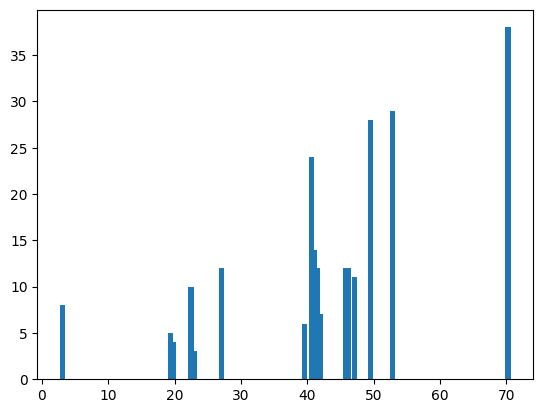

In [25]:
top_comments_df['rank'] = .5 * top_comments_df.rounds + .5 * top_comments_df.balance
plt.bar(top_comments_df['rank'] * 100, top_comments_df.replies)

Not too bad. Now we can show the top 5 debating threads as a tree for easy reading:

In [26]:
def render(xml):
  from IPython.display import HTML
  template = """
  <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.3/dist/js/bootstrap.min.js"></script>
  <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.3/dist/css/bootstrap.min.css">
  %s"""
  return HTML(template % xml)

output = '<ul>'
for id,top_comment in top_comments_df.sort_values(['rank'], ascending=False).iterrows():
  output += f'<li>{top_comment.author}: {top_comment.text} ({top_comment.publishedAt})'
  output += f'<button class="btn btn-primary" data-bs-toggle="collapse" data-bs-target="#thread-{id}"> + </button></li>'
  output += f'<ul class="collapse" id="thread-{id}">'
  for idx, reply in replies_df[replies_df.parent == id].iterrows():
    output += f'<li>{reply.author}: {reply.reply_text} ({reply.publishedAt})</li>'
  output += '</ul>'
output += '</ul>'
render(output)
